In [2]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain
from matplotlib.patches import ConnectionPatch

from multimodal_emg import emg_wave_model
from multimodal_emg import three_stage_fit
from tests.test_multimodal_emg import EchoMultiModalTester

In [5]:

np.random.seed(3008)

# echo parameter definition
fs = 3e5
time_interval = 5e-3
x = np.arange(0, time_interval, 1 / fs)
gt_data = np.zeros(len(x))
gt_params = []
echo_num = 4
alphas = np.random.standard_normal(size=echo_num) + 5.5
mus = np.random.uniform(low=0.001, high=time_interval * 0.9, size=echo_num)
sigmas = np.random.uniform(low=5e-5, high=1e-4, size=echo_num)
etas = np.random.uniform(low=2, high=6, size=echo_num)
fkhzs = 4e1 + (np.random.uniform(size=echo_num)-.5) * 1e-2
phis = np.random.uniform(low=-np.pi, high=+np.pi, size=echo_num)

# custom parameter change to demonstrate capability
sigmas[1] *= 2

# create echoes
for i in range(echo_num):
    gt_data += emg_wave_model(
        alpha=alphas[i],
        mu=mus[i],
        sigma=sigmas[i],
        eta=etas[i],
        fkhz=fkhzs[i],
        phi=phis[i],
        x=x,
    )
    gt_params.append([alphas[i], mus[i], sigmas[i], etas[i], fkhzs[i], phis[i]])

# normalization  and signed 8-bit quantization
gt_data = np.round(gt_data/(max(abs(gt_data)))*117).astype(np.int8)

# add noise to disturb echo detection
data_arr = EchoMultiModalTester.add_noise(gt_data, 10)

echo_list = [
    [325, 364, 8.7927324613085, 117.7634958881404, 0.27466666666666667, 78], 
    [449, 468, 13.014158223359411, 91.82957799556831, 0.27466666666666667, 38], 
    [742, 761, 21.197091240316798, 68.25852001312091, 0.27466666666666667, 38], 
    [1183, 1205, 7.922441719367008, 108.61894408574061, 0.27466666666666667, 44],
]

# add oscillating estimates (alpha, mu, sigma, skew) for optimization
echo_feats = list(
    chain(
        *[
            # alpha, mu in s, sigma in s, eta
            [echo_list[i][3], echo_list[i][1]/fs, (x[echo_list[i][1]]-x[echo_list[i][0]])/3, 3, 4e1, 0]
            for i in range(len(echo_list))
        ]
    )
)

p_star, wav_result = three_stage_fit(
    data_arr,
    features=np.array(echo_feats),
    x=x,
)

In [6]:
data_psnr = 20*np.log((2**8-1) / (np.sum((gt_data - data_arr)**2)/len(gt_data))**.5)
print("Data PSNR amounts to  %s dB" % round(data_psnr, 4))

emg_psnr = 20*np.log((2**8-1) / (np.sum((gt_data - wav_result)**2)/len(gt_data))**.5)
print("EMG PSNR amounts to  %s dB" % round(emg_psnr, 4))

Data PSNR amounts to  65.0596 dB
EMG PSNR amounts to  104.9087 dB


/tmp/ipykernel_12488/3450315880.py:77: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([l1, l2, l3, l4], labels=labels, fontsize=18, loc="upper right", fancybox=True, framealpha=1)


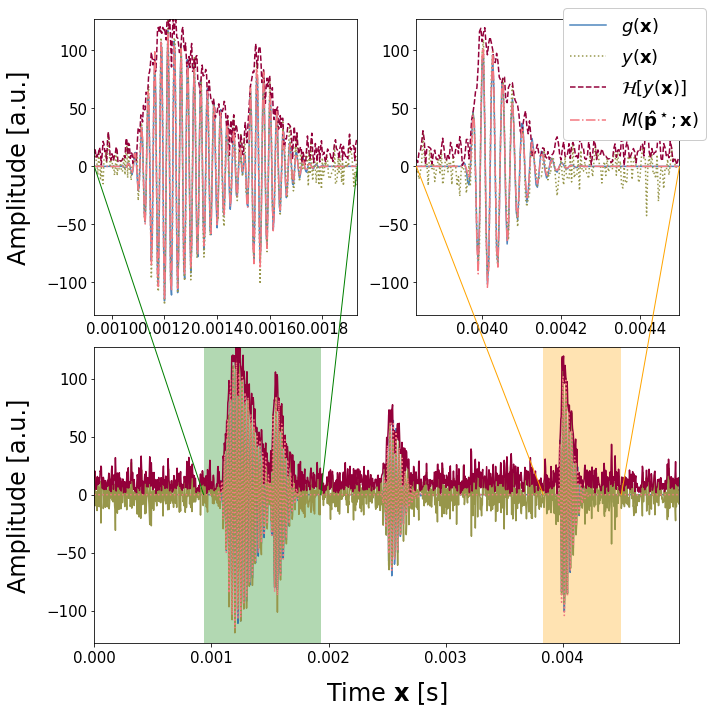

In [7]:
def mulitmodal_ius_plot(x, data, hilbert_data, gt_data=None, fitted_data=None, title=None):

    colors = ['#0051a2', '#97964a', '#ffd44f', '#f4777f', '#93003a']

    # Create main container
    fig = plt.figure(figsize=(10, 10))
    plt.subplots_adjust(bottom = 0., left = 0, top = 1., right = 1)

    # Create first axes, the top-left plot with green plot
    sub1 = fig.add_subplot(2,2,1) # two rows, two columns, fist cell
    xs1, xs2 = 280, 580
    sub1.plot(x[xs1:xs2], gt_data[xs1:xs2], color=colors[0], linestyle='solid', alpha=.7, label="$g(\mathbf{x})$ ground-truth")
    sub1.plot(x[xs1:xs2], data[xs1:xs2], linestyle='dotted', color=colors[1], label="$y(\mathbf{x})$ noisy signal")
    sub1.plot(x[xs1:xs2], hilbert_data[xs1:xs2], linestyle='dashed', color=colors[4], label="$\mathcal{H}[y(\mathbf{x})]$ Hilbert-transform")
    sub1.plot(x[xs1:xs2], fitted_data[xs1:xs2], color=colors[3], linestyle='dashdot', label="$M(\mathbf{\hat{p}^\star};\mathbf{x})$ Oscillation-EMG")
    sub1.set_xlim(x[xs1], x[xs2])
    sub1.set_ylim(-128, 127)
    sub1.set_ylabel(r'Amplitude [a.u.]', fontsize=24, labelpad = 15)
    sub1.tick_params(axis='both', which='major', labelsize=15)
    sub1.tick_params(axis='both', which='minor', labelsize=13)

    # Create second axes, the top-left plot with orange plot
    sub2 = fig.add_subplot(2,2,2) # two rows, two columns, second cell
    xs3, xs4 = 1150, 1350
    sub2.plot(x[xs3:xs4], gt_data[xs3:xs4], color=colors[0], linestyle='solid', alpha=.7, label="$g(\mathbf{x})$ ground-truth")
    sub2.plot(x[xs3:xs4], data[xs3:xs4], linestyle='dotted', color=colors[1], label="$y(\mathbf{x})$ noisy signal")
    sub2.plot(x[xs3:xs4], hilbert_data[xs3:xs4], linestyle='dashed', color=colors[4], label="$\mathcal{H}[y(\mathbf{x})]$ Hilbert-transform")
    sub2.plot(x[xs3:xs4], fitted_data[xs3:xs4], color=colors[3], linestyle='dashdot', label="$M(\mathbf{\hat{p}^\star};\mathbf{x})$ Oscillation-EMG")
    sub2.set_xlim(x[xs3], x[xs4])
    sub2.set_ylim(-128, 127)
    sub2.tick_params(axis='both', which='major', labelsize=15)
    sub2.tick_params(axis='both', which='minor', labelsize=13)

    # Create third axes, a combination of third and fourth cell
    sub3 = fig.add_subplot(2,2,(3,4)) # two rows, two colums, combined third and fourth cell
    (l1,) = sub3.plot(x, gt_data, color = colors[0], alpha = .7, label="$g(\mathbf{x})$ ground-truth")
    (l2,) = sub3.plot(x, data, color=colors[1], label="$y(\mathbf{x})$ noisy signal")
    (l3,) = sub3.plot(x, hilbert_data, color=colors[4], label="$\mathcal{H}[y(\mathbf{x})]$ Hilbert-transform")
    (l4,) = sub3.plot(x, fitted_data, color=colors[3], linestyle=":", label="$M(\mathbf{\hat{p}^\star};\mathbf{x})$ Oscillation-EMG")
    sub3.set_xlim(min(x), max(x))
    sub3.set_ylim(-128, 127)
    sub3.set_xlabel(r'Time $\mathbf{x}$ [s]', fontsize=24, labelpad = 15)
    sub3.set_ylabel(r'Amplitude [a.u.]', fontsize=24, labelpad = 15)
    sub3.tick_params(axis='both', which='major', labelsize=15)
    sub3.tick_params(axis='both', which='minor', labelsize=13)

    # Create blocked area in third axes
    sub3.fill_between((x[xs1],x[xs2]), 127, -128, facecolor='green', alpha=0.3) # blocked area for first axes
    sub3.fill_between((x[xs3],x[xs4]), 127, -128, facecolor='orange', alpha=0.3) # blocked area for second axes

    # Create left side of Connection patch for first axes
    con1 = ConnectionPatch(xyA=(x[xs1], x[xs1]), coordsA=sub1.transData, 
                        xyB=(x[xs1], x[xs1]), coordsB=sub3.transData, color = 'green')
    # Add left side to the figure
    fig.add_artist(con1)

    # Create right side of Connection patch for first axes
    con2 = ConnectionPatch(xyA=(x[xs2], x[xs2]), coordsA=sub1.transData, 
                        xyB=(x[xs2], x[xs2]), coordsB=sub3.transData, color = 'green')
    # Add right side to the figure
    fig.add_artist(con2)

    # Create left side of Connection patch for second axes
    con3 = ConnectionPatch(xyA=(x[xs3], x[xs3]), coordsA=sub2.transData, 
                        xyB=(x[xs3], x[xs3]), coordsB=sub3.transData, color = 'orange')
    # Add left side to the figure
    fig.add_artist(con3)

    # Create right side of Connection patch for second axes
    con4 = ConnectionPatch(xyA=(x[xs4], x[xs4]), coordsA=sub2.transData, 
                        xyB=(x[xs4], x[xs4]), coordsB=sub3.transData, color = 'orange')
    # Add right side to the figure
    fig.add_artist(con4)

    fig.suptitle(title, fontsize=20)
    labels = ["$g(\mathbf{x})$", "$y(\mathbf{x})$", "$\mathcal{H}[y(\mathbf{x})]$", "$M(\mathbf{\hat{p}^\star};\mathbf{x})$"]
    fig.legend([l1, l2, l3, l4], labels=labels, fontsize=18, loc="upper right", fancybox=True, framealpha=1)

    # Save figure with nice margin
    plt.tight_layout()
    plt.savefig('./docs/figs/denoising_emg.svg', dpi = 300, pad_inches = .1)
    plt.show()

mulitmodal_ius_plot(x, data_arr, EchoMultiModalTester.hilbert_transform(data_arr), gt_data=gt_data, fitted_data=wav_result, title=None)